In [6]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

In [7]:
from collections import namedtuple
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [8]:

path = '/hdd/team_2/Cityscapes/'
images_train_path = os.path.join(path,'leftImg8bit','train_extra')
images_train = sorted(glob.glob(os.path.join(images_train_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

mask_train_path = os.path.join(path,'gtCoarse', 'gtCoarse','train_extra')
mask_train = sorted(glob.glob(os.path.join(mask_train_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_train_path, len(mask_train)))

images_valid_path = os.path.join(path,'leftImg8bit_trainvaltest','leftImg8bit', 'val')
images_valid = sorted(glob.glob(os.path.join(images_valid_path, "**/*.png"), recursive=True))
print("IMAGES {} ### Total:  {}".format(images_valid_path, len(images_valid)))

mask_valid_path = os.path.join(path,'gtCoarse', 'gtCoarse','val',)
mask_valid = sorted(glob.glob(os.path.join(mask_valid_path, "**/*color.png"), recursive=True))
print("MASK {} ### Total:  {}".format(mask_valid_path, len(mask_valid)))


IMAGES /hdd/team_2/Cityscapes/leftImg8bit/train_extra ### Total:  19998
MASK /hdd/team_2/Cityscapes/gtCoarse/gtCoarse/train_extra ### Total:  19998
IMAGES /hdd/team_2/Cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val ### Total:  500
MASK /hdd/team_2/Cityscapes/gtCoarse/gtCoarse/val ### Total:  500


In [9]:
df_train_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])
df_train_city['rgb_path'] = images_train
df_train_city['mask_path'] = mask_train
df_train_city['dataset']  = 'CITYSCAPES'
df_train_city['class'] = 1 # On-road Data

df_train_city, df_test_city = train_test_split(df_train_city, test_size=0.20, random_state=42)
df_valid_city = pd.DataFrame(columns=['rgb_path','depth_path','mask_path','dataset'])

df_valid_city['rgb_path'] = images_valid
df_valid_city['mask_path'] = mask_valid
df_valid_city['dataset']  = 'CITYSCAPES'
df_valid_city['class'] = 1 # On-road Data
print("########")
print("train data: {}".format(len(df_train_city)))
print("test data: {}".format(len(df_test_city)))
print("val data: {}".format(len(df_valid_city)))
print("########")

########
train data: 15998
test data: 4000
val data: 500
########


In [10]:
def pixels_class_density(labels, mask_path, filename):
    
    label_pixel_counts = {label.name: 0 for label in labels}

    with tqdm(total=len(mask_path), colour='#3eedc4') as t:

        for image_path in mask_path:
            
            
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pixel_labels = np.array(image)
        
            for label in labels:  
                c = np.array(label.color)
                label_mask = np.all(pixel_labels == c, axis=-1).astype(np.uint8)
                label_pixel_counts[label.name] += np.sum(label_mask)

            t.update(1)
    
    # with open(filename, 'w') as json_file:
    #     json.dump(label_pixel_counts, json_file, indent=4)
            
    return label_pixel_counts

In [11]:
# print("TRAIN SET ANALYSIS")
# dict_train  = pixels_class_density(labels=labels,
#                                     mask_path=df_train_city['mask_path'][:200],
#                                     filename='pixels_tmp.json')

In [12]:
import json
 
# Opening JSON file
f = open('pixels_test.json')
pixels_test = json.load(f)

f = open('pixels_valid.json')
pixels_valid = json.load(f)

f = open('pixels_train.json')
pixels_train = json.load(f)

In [13]:
# List of keys to remove
keys_to_remove = [
    'unlabeled', 'ego vehicle', 'rectification border', 
    'out of roi', 'static', 'dynamic', 'ground'
]
# Remove specified keys using a dictionary comprehension
pixels_test = {k: v for k, v in pixels_test.items() if k not in keys_to_remove}
pixels_valid = {k: v for k, v in pixels_valid.items() if k not in keys_to_remove}
pixels_train = {k: v for k, v in pixels_train.items() if k not in keys_to_remove}

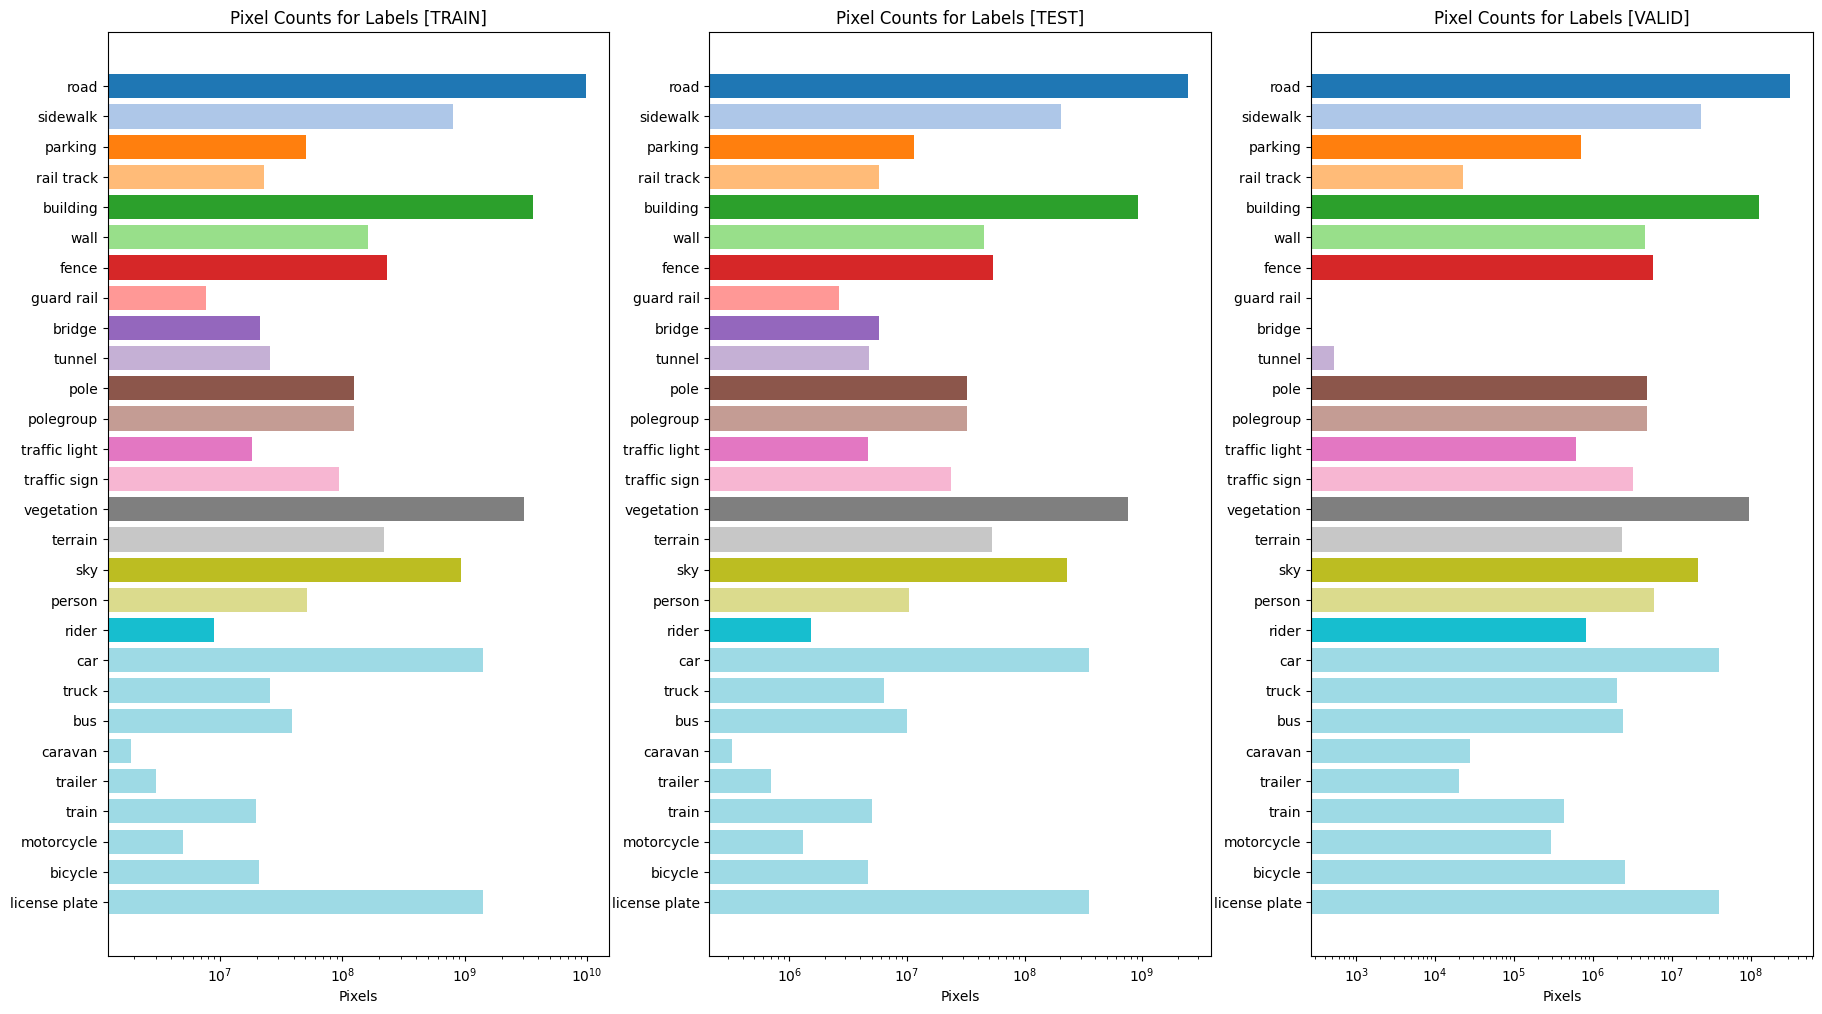

In [30]:
colors = plt.cm.tab20(range(len(labels)))


# Define the data and get the labels and pixel counts
labels = list(pixels_test.keys())
pixel_counts_test = list(pixels_test.values())
pixel_counts_valid = list(pixels_valid.values())
pixel_counts_train = list(pixels_train.values())


# Get the 'tab20' colormap
fig, axs = plt.subplots(1,3 , figsize=(22, 12))


axs[0].barh(labels, pixel_counts_train, color=colors)
axs[0].set_xlabel('Pixels')
axs[0].set_title('Pixel Counts for Labels [TRAIN]')
axs[0].invert_yaxis()
axs[0].set_xscale("log")

axs[1].barh(labels, pixel_counts_test, color=colors)
axs[1].set_xlabel('Pixels')
axs[1].set_title('Pixel Counts for Labels [TEST]')
axs[1].invert_yaxis()
axs[1].set_xscale("log")

axs[2].barh(labels, pixel_counts_valid, color=colors)
axs[2].set_xlabel('Pixels')
axs[2].set_title('Pixel Counts for Labels [VALID]')
axs[2].invert_yaxis()
axs[2].set_xscale("log")